# Sample Code for an Autoencoder for Dr. Goswami
## Shakil Rafi

In this notebook we will do a test-case with synthetic data comparing classic PCA with an autoencoder to see that the autoencoder is able to take high-dimensional data and extract out the relevant features. 

**Dataset**

Our dataset will be a synthetic dataset in which we will use tha sklearn datasets method to create eight "blobs" of data. Each blob has a centroid around which the data is clustered in a Gaussian fashion with a standard deviation of 2, i.e. each element of the cluster $c$, $x_c$ is such that $x_c \sim \mathcal{N}(\text{centroid}_c,1)$. We will have nine features to the data, to which we will add an extra feature, consisting of noise coming from a uniform distribution.

*Note on dataset*: The author regrets to inform that due to the ongoing shutdowns of internet and communications in Bangladesh that they have had difficulty and delay obtaining actual datasets. This Jupyter notebook therefore serves as a proof of concept that autoencoders can be beneficial and viable in analyzing genomic data via proxy with synthetic data. The author apologizes for this inconvenience.

In [1]:
####################################################################################
#
# The current cell installs packages if not already installed in the hosts systems.
# This is supplemented by an extensive requirements.txt file in the folder
#
####################################################################################

# import subprocess
# import sys

# def install(package):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # List your packages here
# packages = ["numpy", "pandas", "seaborn","keras","tensorflow","matplotlib", "scikit-learn"]

# for package in packages:
#     install(package)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.datasets import make_blobs

In [4]:
data = make_blobs(
    n_samples=30000, 
    n_features=9, 
    centers=8, 
    cluster_std=2
)

X,y = data

In [5]:
np.random.seed(seed=101)
noise = np.random.uniform(size=len(X))
noise = pd.Series(noise)

In [6]:
feat = pd.DataFrame(X)
feat = pd.concat([feat,noise],axis=1)

In [7]:
feat.columns = [f"X{i+1}" for i in range(len(feat.columns))]

In [8]:
feat

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,3.832150,-0.885521,1.396813,6.518364,-7.181659,7.624980,9.863516,-3.958961,10.142876,0.516399
1,5.121997,-9.531866,-6.580018,3.576645,-3.133651,-3.158619,-7.563490,6.267551,-0.000102,0.570668
2,0.170303,-3.953752,8.746255,4.652394,1.368011,-0.426606,2.571776,-7.456172,-9.752707,0.028474
3,2.087428,-2.992573,5.104202,6.203770,0.087370,-4.681826,5.966582,-0.207810,-7.504352,0.171522
4,9.513307,6.389279,-2.908372,-0.090795,-6.912397,2.130114,-9.692870,5.897349,1.681667,0.685277
...,...,...,...,...,...,...,...,...,...,...
29995,13.124232,8.117214,8.370973,9.811386,0.173668,4.734505,2.027921,-5.618596,7.445326,0.655720
29996,2.451051,-4.309338,3.712033,5.494899,0.206910,-1.965390,4.748489,-4.381654,-7.359769,0.298044
29997,-0.500273,0.921920,2.131400,3.418651,-6.197750,11.418829,5.531861,2.188421,5.244825,0.537972
29998,3.285187,0.026805,6.310630,5.544782,-0.692804,-0.721316,4.952729,-3.549326,-3.656935,0.513805


In [9]:
feat.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,6.880943,1.773305,-0.392525,5.431513,-2.360405,1.193830,1.046358,-0.117281,-0.424195,0.500133
std,3.450987,7.130533,7.150479,3.050602,4.372199,5.664284,6.621440,4.890498,5.874961,0.289540
min,-5.490365,-17.244616,-17.053376,-4.412489,-17.099587,-13.346374,-16.299739,-12.580435,-16.440133,0.000002
25%,4.730572,-4.391468,-7.417902,3.151284,-5.552574,-3.265249,-5.086935,-3.982851,-4.665434,0.247814
50%,7.459597,3.072980,0.064210,5.355945,-1.532697,0.390769,2.553161,-1.276105,-1.152058,0.499429
75%,9.374422,8.119963,6.353483,7.721868,1.037876,6.500394,6.235492,3.957791,3.830021,0.750924
max,17.518416,16.887564,14.705751,15.562946,10.309994,15.120596,16.109644,14.901781,15.729132,0.999985


In [10]:
feat.to_csv("feat.csv")

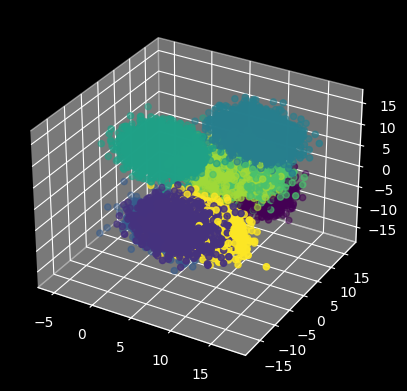

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(feat['X1'],feat['X2'],feat['X9'], c = y)

### Preprocessing the data

We will use the standard MinMaxScaler from sklearn to scale and preprocess the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(feat)

### The PCA decomposition

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

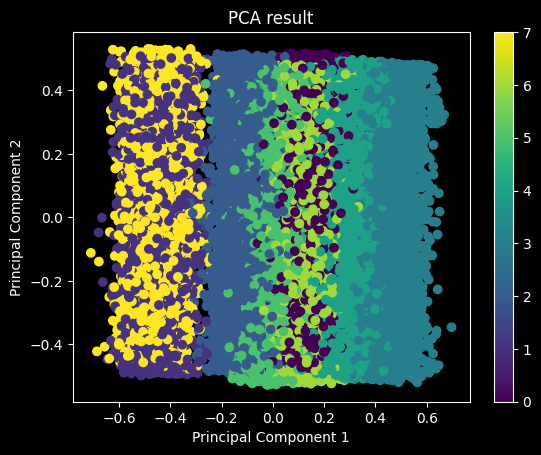

In [14]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y)
plt.title('PCA result')
plt.colorbar()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

X_reconstructed = pca.inverse_transform(pca_result)
print("Reconstruction loss of PCA:",mean_squared_error(X_reconstructed, scaled_data))


Reconstruction loss of PCA: 0.021622192886071475


#### K-means done on the encoded data

We now seek to apply classic K-Means on this PCA-result. We will do the same on the 

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans_for_pca = KMeans(n_clusters=8)
kmeans_for_pca.fit(pca_result)

KMeans()

In [18]:
kmeans_for_pca.cluster_centers_

array([[-0.44910219, -0.23529575],
       [-0.04385551,  0.0132341 ],
       [-0.43505372,  0.26351184],
       [ 0.03283007, -0.34681073],
       [ 0.39055912, -0.30722012],
       [ 0.40882084,  0.27793082],
       [ 0.22417627, -0.01915176],
       [ 0.06386291,  0.34105549]])

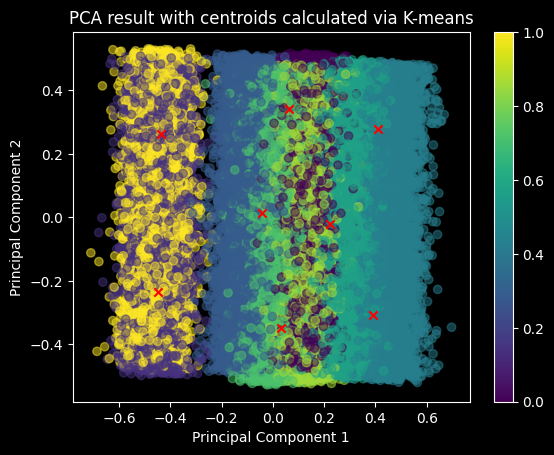

In [19]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, alpha=0.5)
plt.scatter(kmeans_for_pca.cluster_centers_[:,0],kmeans_for_pca.cluster_centers_[:,1],marker='x',c='red')
plt.title('PCA result with centroids calculated via K-means')
plt.colorbar()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [20]:
kmeans_for_pca.inertia_

665.493846052085

### The autoencoder decomposition

We will now create an autoencoder

10 --> 5 --> 2 --> 5 --> 10

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [22]:
# # This is the input layer
# input_layer = Input(shape=(scaled_data.shape[1],))

# # This is the encoding layers
# encoded = Dense(8, activation='relu')(input_layer)
# encoded = Dense(6, activation='relu')(encoded)
# encoded = Dense(2, activation='relu')(encoded)

# # This is the decoding layers
# decoded = Dense(2, activation='relu')(encoded)
# decoded = Dense(6, activation='relu')(decoded)
# decoded = Dense(8, activation='relu')(decoded)
# decoded = Dense(scaled_data.shape[1], activation='linear')(decoded)


# # This is the full autoencoder
# autoencoder = Model(inputs=input_layer, outputs=decoded)

In [23]:
input_layer = Input(shape=(scaled_data.shape[1],))

# Define the encoding layers
encoded = Dense(8, activation='sigmoid')(input_layer)
encoded = Dense(6, activation='sigmoid')(encoded)
encoded_output = Dense(2, activation='linear')(encoded)

# Define the encoder model
encoder = Model(inputs=input_layer, outputs=encoded_output)

# Define the decoding layers
encoded_input = Input(shape=(2,))
decoded = Dense(6, activation='sigmoid')(encoded_input)
decoded = Dense(8, activation='sigmoid')(decoded)
decoded_output = Dense(scaled_data.shape[1], activation='sigmoid')(decoded)

# Define the decoder model
decoder = Model(inputs=encoded_input, outputs=decoded_output)

# Define the autoencoder model
autoencoder_input = Input(shape=(scaled_data.shape[1],))
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

autoencoder = Model(inputs=autoencoder_input, outputs=reconstructed)

# Print model summaries
print("Encoder summary:")
encoder.summary()
print("\nDecoder summary:")
decoder.summary()
print("\nAutoencoder summary:")
autoencoder.summary()

Encoder summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (624.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 0 (0.00 B)


Decoder summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164 (656.00 B)

 Trainable params: 164 (656.00 B)

 Non-trainable params: 0 (0.00 B)


Autoencoder summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 2)              │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 10)             │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 2)              │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 10)             │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
autoencoder.compile(loss='mse', 
                    optimizer=SGD(learning_rate=0.01))

In [26]:
autoencoder.fit(scaled_data, 
                scaled_data, 
                batch_size = 64,
                shuffle = True,
                epochs = 50)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0658
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0600
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0549
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.0507
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.0478
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.0453
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.0436
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 0.0423
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0414
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.0409
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.0404
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.0400
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0399
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0398
Epoch 15/50
469/469 ━━━━━━━━━

In [27]:
encoder = Model(inputs=input_layer, outputs=encoded)
encoded_2dim = encoder.predict(scaled_data)

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


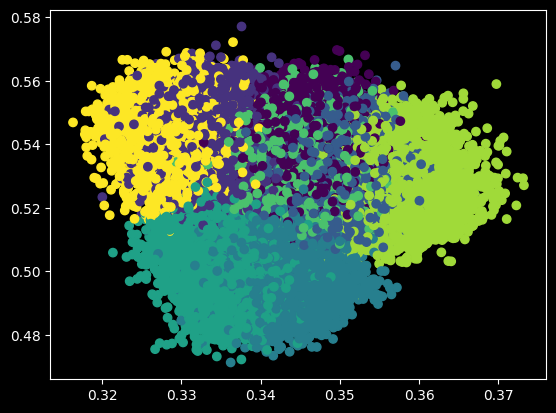

In [28]:
plt.scatter(encoded_2dim[:,0],encoded_2dim[:,1], c = y)

In [29]:
kmeans_for_autoencoder = KMeans(n_clusters=8)
kmeans_for_autoencoder.fit(encoded_2dim)

KMeans()

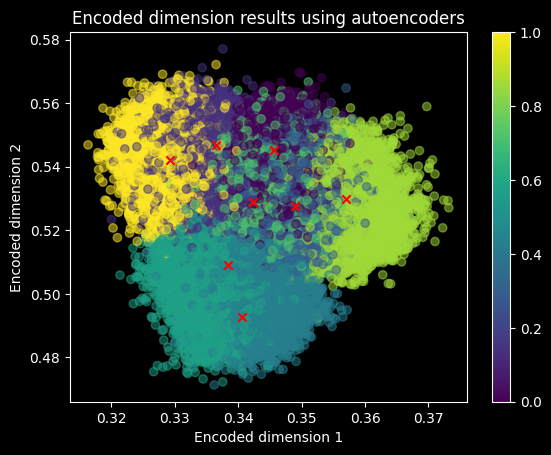

In [30]:
plt.scatter(encoded_2dim[:, 0], encoded_2dim[:, 1], c=y, alpha=0.5)
plt.scatter(kmeans_for_autoencoder.cluster_centers_[:,0],kmeans_for_autoencoder.cluster_centers_[:,1],marker='x',c='red')
plt.title('Encoded dimension results using autoencoders')
plt.colorbar()
plt.xlabel("Encoded dimension 1")
plt.ylabel("Encoded dimension 2")
plt.show()

In [31]:
kmeans_for_autoencoder.inertia_

6.157865047454834

In [32]:
kmeans_for_pca.inertia_

665.493846052085

In [33]:
kmeans_for_pca.labels_

array([6, 2, 3, ..., 6, 1, 2], dtype=int32)

In [34]:
from sklearn.metrics import silhouette_score

In [35]:
silhouette_score(scaled_data,kmeans_for_pca.labels_)

0.13132647285236687

In [36]:
silhouette_score(scaled_data, kmeans_for_autoencoder.labels_)

0.19285495491413215